# Normalization and pre-tokenization

Install the Transformers, Datasets, and Evaluate libraries to run this notebook.

In [1]:
%%capture
!pip install datasets evaluate transformers[sentencepiece]

Also, log into Hugging face.

In [2]:
from huggingface_hub import notebook_login

notebook_login()

Before we dive more deeply into the <font color='blue'>three most common</font> subword <font color='blue'>tokenization algorithms</font> used with Transformer models (<font color='blue'>Byte-Pair Encoding</font> or BPE, <font color='blue'>WordPiece</font>, and <font color='blue'>Unigram</font>), we'll first take a look at the <font color='blue'>preprocessing</font> that <font color='blue'>each tokenizer applies</font> to <font color='blue'>text</font>. Here's a <font color='blue'>high-level overview</font> of the steps in the <font color='blue'>tokenization pipeline</font>:

<div class="flex justify-center">
<img class="block dark:hidden" src="https://huggingface.co/datasets/huggingface-course/documentation-images/resolve/main/en/chapter6/tokenization_pipeline.svg" alt="The tokenization pipeline.">
</div>

Before <font color='blue'>splitting</font> a <font color='blue'>text</font> into <font color='blue'>subtokens</font> (according to its model), the tokenizer performs two steps: <font color='blue'>normalization</font> and <font color='blue'>pre-tokenization</font>.

## Normalization

The normalization step involves some general <font color='blue'>cleanup</font>, such as <font color='blue'>removing</font> needless <font color='blue'>whitespace</font>, <font color='blue'>lowercasing</font>, and/or <font color='blue'>removing accents</font>. If you're familiar with [Unicode normalization](http://www.unicode.org/reports/tr15/) (such as NFC or NFKC), this is also something the tokenizer may apply.

The 🤗 Transformers `tokenizer` has an attribute called <font color='blue'>`backend_tokenizer`</font> that provides <font color='blue'>access</font> to the <font color='blue'>underlying tokenizer</font> from the 🤗 Tokenizers library:


In [4]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
print(type(tokenizer.backend_tokenizer))

<class 'tokenizers.Tokenizer'>


The <font color='blue'>`normalizer` attribute</font> of the <font color='blue'>`tokenizer` object</font> has a <font color='blue'>`normalize_str()` method</font> that we can use to see how the normalization is performed:

In [5]:
print(tokenizer.backend_tokenizer.normalizer.normalize_str("Héllò hôw are ü?"))

hello how are u?


In this example, since we picked the <font color='blue'>`bert-base-uncased` checkpoint</font>, the normalization applied <font color='blue'>lowercasing</font> and <font color='blue'>removed</font> the <font color='blue'>accents</font>.

<Tip>

✏️ **Try it out!** Load a tokenizer from the <font color='blue'>`bert-base-cased` checkpoint</font> and pass the <font color='blue'>same example</font> to it. What are the <font color='blue'>main differences</font> you can see between the <font color='blue'>cased</font> and <font color='blue'>uncased</font> versions of the tokenizer?

</Tip>

In [14]:
# Exercise

# BERT uncased
tokenizer_uncased = AutoTokenizer.from_pretrained("bert-base-uncased")
print("BERT Uncased:", tokenizer_uncased.backend_tokenizer.normalizer.normalize_str("Héllò hôw are ü?"))

# BERT cased
tokenizer_cased = AutoTokenizer.from_pretrained("bert-base-cased")
print("BERT Cased:", tokenizer_cased.backend_tokenizer.normalizer.normalize_str("Héllò hôw are ü?"))

BERT Uncased: hello how are u?
BERT Cased: Héllò hôw are ü?


We see that the <font color='blue'>cased</font> version <font color='blue'>preserves</font> both the <font color='blue'>original case</font> and the <font color='blue'>accents</font>, while the <font color='blue'>uncased</font> version <font color='blue'>removes accents</font> and <font color='blue'>converts to lowercase</font>.

## Pre-tokenization
As we will see in the next sections, a <font color='blue'>tokenizer</font> <font color='blue'>cannot be trained</font> on <font color='blue'>raw text alone</font>. Instead, we first need to <font color='blue'>split the texts</font> into <font color='blue'>small entities</font>, like words. That's where the <font color='blue'>pre-tokenization step</font> comes in. As we saw in [Chapter 2](https://huggingface.co/learn/llm-course/chapter2/4), a <font color='blue'>word-based tokenizer</font> can <font color='blue'>split</font> <font color='blue'>raw text</font> into <font color='blue'>words</font> on <font color='blue'>whitespace</font> and <font color='blue'>punctuation</font>. Those words will be the <font color='blue'>boundaries of the subtokens</font> the <font color='blue'>tokenizer can learn</font> during its training.

To see how a <font color='blue'>fast tokenizer</font> performs <font color='blue'>pre-tokenization</font>, we can use the <font color='blue'>`pre_tokenize_str()` method</font> of the `pre_tokenizer` attribute of the `tokenizer` object:


In [6]:
tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str("Hello, how are  you?")

[('Hello', (0, 5)),
 (',', (5, 6)),
 ('how', (7, 10)),
 ('are', (11, 14)),
 ('you', (16, 19)),
 ('?', (19, 20))]

Notice how the tokenizer is already <font color='blue'>keeping track</font> of the <font color='blue'>offsets</font>, which is how it can <font color='blue'>give us</font> the <font color='blue'>offset mapping</font> we <font color='blue'>used</font> in the <font color='blue'>previous section</font>. Here the tokenizer <font color='blue'>ignores</font> the <font color='blue'>two spaces</font> and <font color='blue'>replaces them</font> with <font color='blue'>just one</font>, but the <font color='blue'>offset jumps</font> between <font color='blue'>are</font> and <font color='blue'>you</font> to account for that.

Since we're using a <font color='blue'>BERT tokenizer</font>, the pre-tokenization involves <font color='blue'>splitting</font> on <font color='blue'>whitespace</font> and <font color='blue'>punctuation</font>. Other tokenizers can have different rules for this step. For example, if we use the <font color='blue'>GPT-2 tokenizer</font>, it will <font color='blue'>split</font> on <font color='blue'>whitespace</font> and <font color='blue'>punctuation</font> as well, but it will <font color='blue'>keep the spaces</font> and <font color='blue'>replace them</font> with a <font color='blue'>`Ġ` symbol</font>, enabling it to recover the original spaces if we decode the tokens:

In [8]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str("Hello, how are  you?")

[('Hello', (0, 5)),
 (',', (5, 6)),
 ('Ġhow', (6, 10)),
 ('Ġare', (10, 14)),
 ('Ġ', (14, 15)),
 ('Ġyou', (15, 19)),
 ('?', (19, 20))]

Also note that unlike the BERT tokenizer, this tokenizer does <font color='blue'>not ignore</font> the <font color='blue'>double space</font>. For a last example, let's have a look at the <font color='blue'>T5 tokenizer</font>, which is based on the <font color='blue'>SentencePiece algorithm</font>:


In [10]:
tokenizer = AutoTokenizer.from_pretrained("t5-small")
tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str("Hello, how are  you?")

[('▁Hello,', (0, 6)),
 ('▁how', (7, 10)),
 ('▁are', (11, 14)),
 ('▁you?', (16, 20))]

Like the GPT-2 tokenizer, this one <font color='blue'>keeps spaces</font> and <font color='blue'>replaces them</font> with a <font color='blue'>specific token (`_`)</font>, but the T5 tokenizer only <font color='blue'>splits on whitespace</font>, not punctuation. Also note that it <font color='blue'>added a space</font> by default at the <font color='blue'>beginning of the sentence</font> (before <font color='blue'>Hello</font>) and <font color='blue'>ignored</font> the <font color='blue'>double space</font> between <font color='blue'>are</font> and <font color='blue'>you</font>.

Now that we've seen a little of how some different tokenizers process text, we can start to <font color='blue'>explore</font> the <font color='blue'>underlying algorithms</font> themselves. We'll begin with a quick look at the broadly widely applicable SentencePiece; then, over the next three sections, we'll examine how the <font color='blue'>three main algorithms</font> used for <font color='blue'>subword tokenization work</font>.


## SentencePiece

[SentencePiece](https://github.com/google/sentencepiece) is a tokenization algorithm for the <font color='blue'>preprocessing of text</font> that you can use with any of the models we will see in the next three sections. It considers the <font color='blue'>text</font> as a <font color='blue'>sequence of Unicode characters</font>, and <font color='blue'>replaces spaces</font> with a <font color='blue'>special character `▁`</font>. Used in <font color='blue'>conjunction</font> with the <font color='blue'>Unigram algorithm</font> (see [section 7](https://huggingface.co/learn/llm-course/chapter6/7)), it <font color='blue'>doesn't</font> even <font color='blue'>require</font> a <font color='blue'>pre-tokenization step</font>, which is very <font color='blue'>useful</font> for <font color='blue'>languages</font> where the <font color='blue'>space character</font> is <font color='blue'>not used</font> (like Chinese or Japanese).

The other main feature of SentencePiece is <font color='blue'>reversible tokenization</font>: since there is <font color='blue'>no special treatment of spaces</font>, <font color='blue'>decoding</font> the <font color='blue'>tokens</font> is done by <font color='blue'>concatenating them</font> and <font color='blue'>replacing</font> the <font color='blue'>`_`s</font> with <font color='blue'>spaces</font> -- this results in the normalized text. As we saw earlier, the <font color='blue'>BERT</font> tokenizer <font color='blue'>removes repeating spaces</font>, so its tokenization is <font color='blue'>not reversible</font>.


## Algorithm overview

In the following sections, we'll dive into the <font color='blue'>three main subword tokenization algorithms</font>: <font color='blue'>BPE</font> (used by GPT-2 and others), <font color='blue'>WordPiece</font> (used for example by BERT), and <font color='blue'>Unigram</font> (used by T5 and others). Before we get started, here's a <font color='blue'>quick overview</font> of <font color='blue'>how they work</font>. Don't hesitate to come back to this table after reading each of the next sections if it doesn't make sense to you yet.


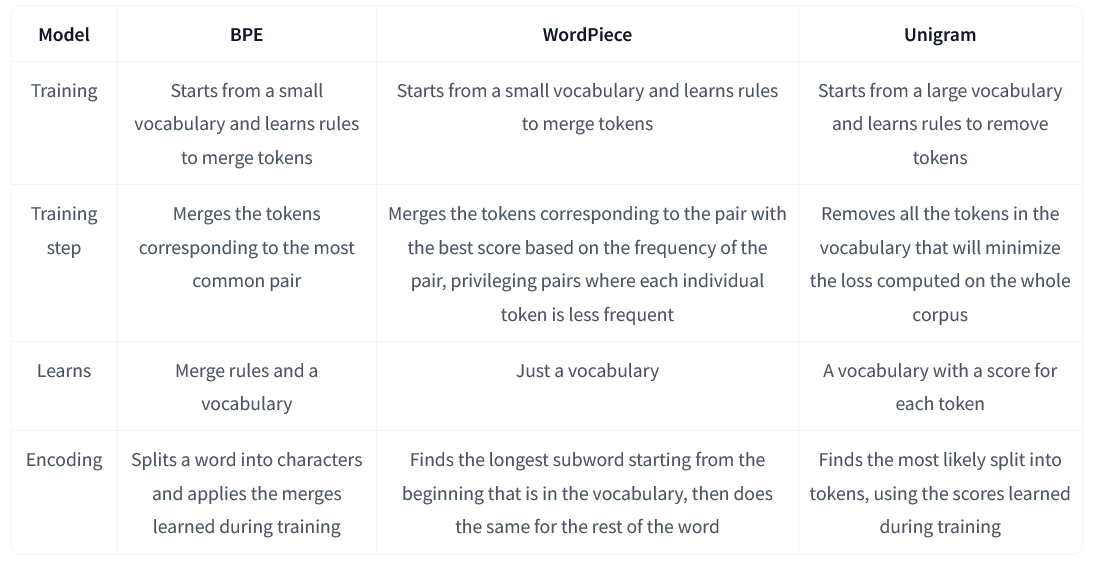

Now let's dive into BPE!